In [16]:
import multiprocessing as mp

# Foundational SSM core imports
from foundational_ssm.loaders import get_brainset_data_loader
from foundational_ssm.constants import DATA_ROOT
from foundational_ssm.samplers import TrialSampler
import os 
import equinox as eqx
import matplotlib.pyplot as plt

mp.set_start_method('spawn', force=True)  # Use 'spawn' for better performance with JAX
data_root = '../' + DATA_ROOT # change to the folder holding the brainsets
config_dir = '../configs/dataset' # change
dataset_args = {
    'keep_files_open': False,
    'lazy': True,
    'split': 'test_trial', # or 'train' 
}
dataloader_args = {
    'batch_size': 256, # Adjust per your system capacity
    'num_workers': 10,
    'persistent_workers': True
}
sampler = 'SequentialFixedWindowSampler'
sampler_args = { 
                'window_length': 3.280,
                'drop_short': False,
                'min_window_length': 0.88
                }

dataset, data_loader, max_neural_units = get_brainset_data_loader(
    dataset_args=dataset_args,
    sampler = sampler,
    sampler_args = sampler_args,
    dataloader_args = dataloader_args,
    sampling_rate = 200,
    dataset_cfg = os.path.join(config_dir, 'pm_t.yaml'),
    data_root = data_root
)

sessions = dataset.get_session_ids() # list of sessions in your dataset
sampling_intervals = dataset.get_sampling_intervals() # list of sampling intervals for each session

/tmp/ipykernel_900834/1426090078.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  max_value = int(np.abs(transformed_vel).max())


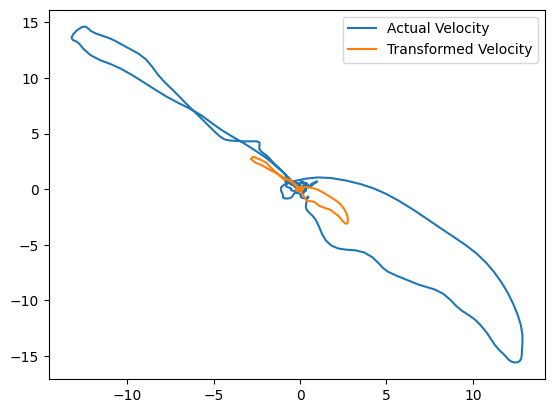

In [11]:
# for session_id, intervals in sampling_intervals.items():
import numpy as np 
from foundational_ssm.transform import transform_brainsets_regular_time_series_smoothed 
max_values = []
error_session_intervals = []
for session_id in sessions:
    if ('perich_miller_population_2018/t' in session_id) and ('center_out' in session_id):
        intervals = sampling_intervals[session_id]
        for i in range(len(intervals.start)):
            start, end = intervals.start[i], intervals.end[i]
            data = dataset.get_recording_data(session_id).slice(start, end) 
            try:
                transformed_data = transform_brainsets_regular_time_series_smoothed(data)
                actual_vel = data.cursor.vel
                actual_timestamps = data.cursor.timestamps
                transformed_vel = transformed_data['behavior_input']
                max_value = int(np.abs(transformed_vel).max())
                max_values.append(max_value)
                if actual_timestamps[0] > 0.01 or max_value > 200:
                    error_session_intervals.append((session_id, start, end))
            except:
                continue
        # print("no invalid transformations found in session", session_id)

import matplotlib.pyplot as plt
plt.plot(actual_vel[:, 0], actual_vel[:, 1], label='Actual Velocity')
plt.plot(transformed_vel[:, 0], transformed_vel[:, 1], label='Transformed Velocity')
plt.legend()

In [6]:
from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb
import equinox as eqx
from foundational_ssm.models import SSMDownstreamDecoder
import jax
artifact_full_name = 'melinajingting-ucl/foundational_ssm_downstream_pm/l2_scratch_all_checkpoint:v14'
model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMDownstreamDecoder)
inf_model = eqx.nn.inference_mode(model)

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 58, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_downstream_pm', 'resume_run_id': None}, 'dataset': {'cfg': [{'selection': [{'brainset': 'perich_miller_population_2018', 'sessions': ['t_20130819_center_out_reaching']}]}], 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_checkpoints': True}, 'input_dim': 625, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'test_trial', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 2

wandb:   3 of 3 files downloaded.  


In [27]:
import equinox as eqx
import jax
import numpy as np
import jax.random as jr
from sklearn.metrics import r2_score 

inf_model = eqx.nn.inference_mode(model)
all_targets = []
all_preds = []
for batch in data_loader: 
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    preds, state = jax.vmap(inf_model, axis_name="batch", in_axes=(0, None, None), out_axes=(0, None))(inputs, state, jr.PRNGKey(0))
    all_targets.append(targets[:, 56:, :])
    all_preds.append(preds[:, 56:, :])

all_targets = np.concatenate(all_targets, axis=0)
all_preds = np.concatenate(all_preds, axis=0)
r2 = r2_score(all_preds.reshape(-1,2), all_targets.reshape(-1,2))
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.7576


/tmp/ipykernel_911930/965446558.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


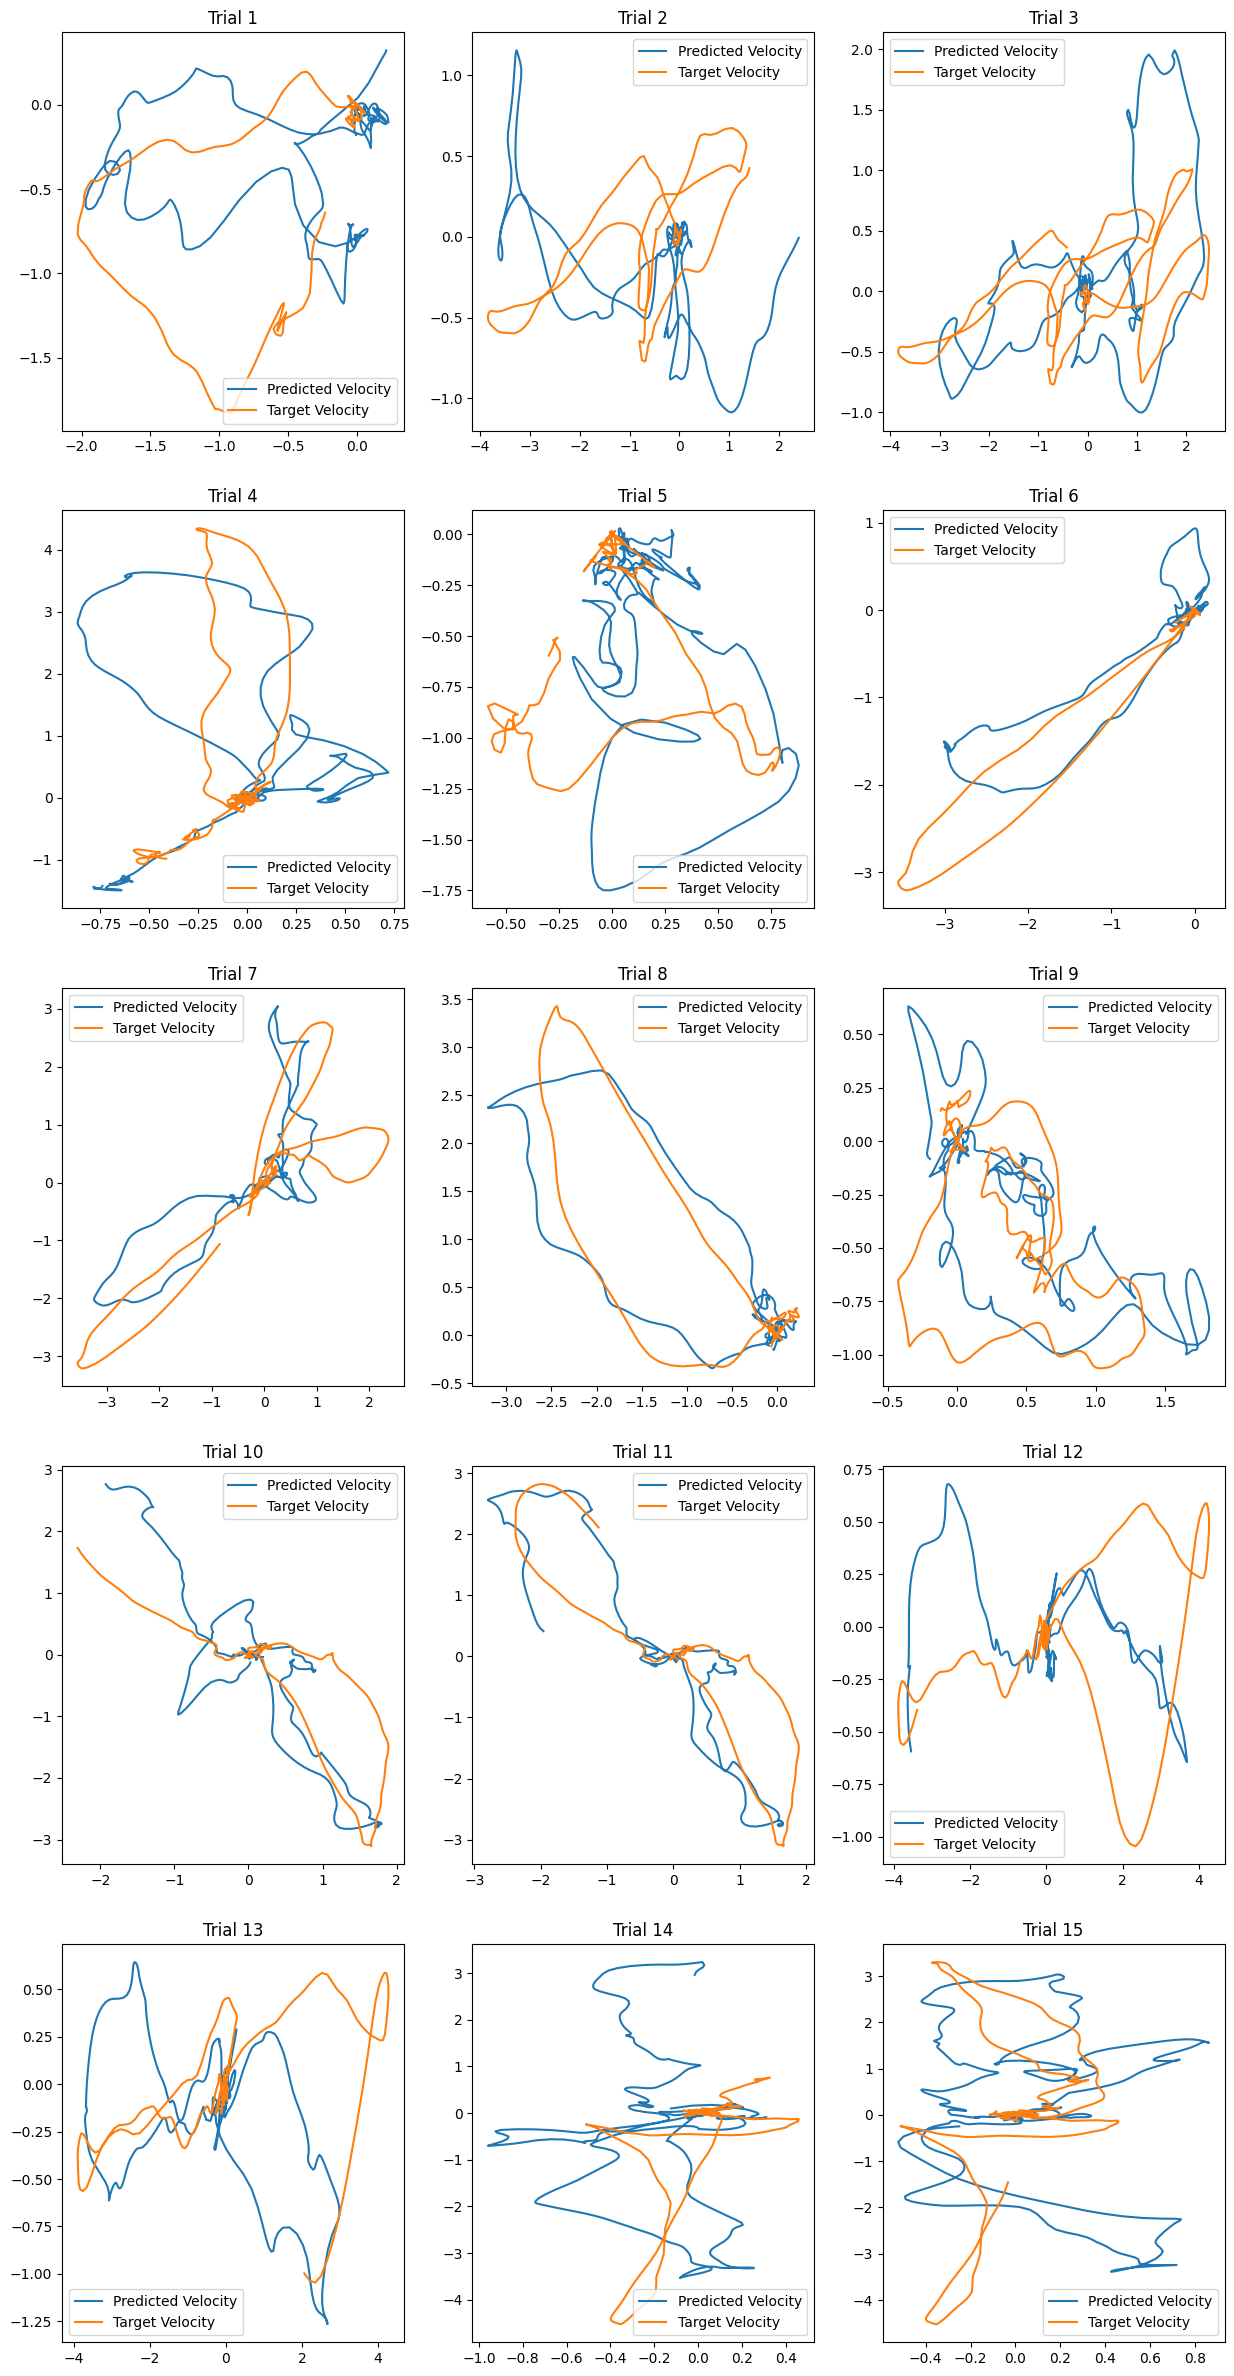

In [28]:
c_co_targets = targets
c_co_preds = preds

fig, axs = plt.subplots(5, 3, figsize=(15, 30))
axs = axs.flatten()
for i in range(15):
    pred = c_co_preds[i]
    target = c_co_targets[i]
    ax = axs[i] 
    ax.plot(pred[:, 0], pred[:, 1], label='Predicted Velocity')
    ax.plot(target[:, 0], target[:, 1], label='Target Velocity')
    ax.set_title(f"Trial {i+1}")
    ax.legend()

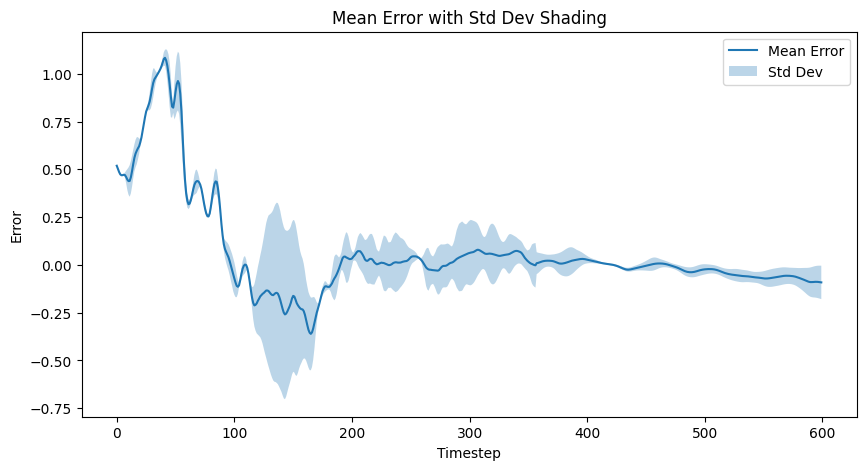

In [29]:
import numpy as np
import matplotlib.pyplot as plt
error = (all_preds - all_targets)[0]
mean_error = np.mean(error, axis=1)
std_error = np.std(error, axis=1)
timesteps = np.arange(mean_error.shape[0])
plt.figure(figsize=(10,5))
plt.plot(timesteps, mean_error, label='Mean Error')
plt.fill_between(timesteps, mean_error - std_error, mean_error + std_error, alpha=0.3, label='Std Dev')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.legend()
plt.title('Mean Error with Std Dev Shading')
plt.show()

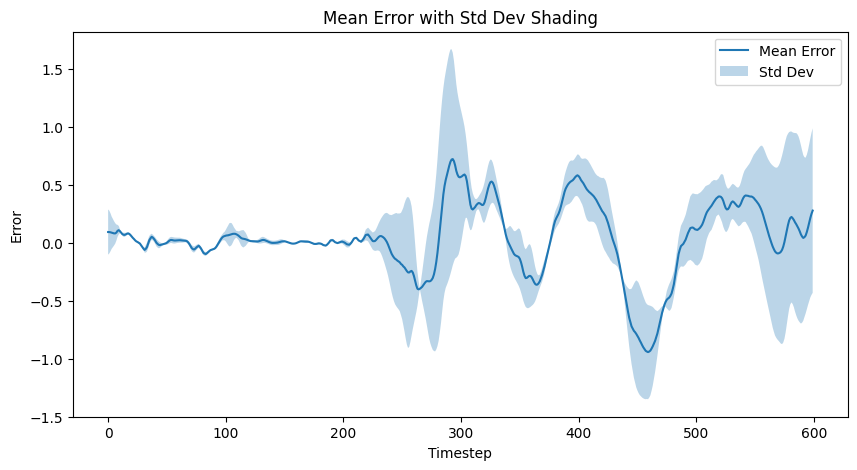

In [31]:
import numpy as np
import matplotlib.pyplot as plt
error = (all_preds - all_targets)[1]
mean_error = np.mean(error, axis=1)
std_error = np.std(error, axis=1)
timesteps = np.arange(mean_error.shape[0])
plt.figure(figsize=(10,5))
plt.plot(timesteps, mean_error, label='Mean Error')
plt.fill_between(timesteps, mean_error - std_error, mean_error + std_error, alpha=0.3, label='Std Dev')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.legend()
plt.title('Mean Error with Std Dev Shading')
plt.show()